In [1]:
addprocs(1) # three additional processes to serve as workers 

1-element Array{Int64,1}:
 2

In [2]:
using Gadfly
using Interpolations 
for p in workers()
           remotecall_fetch(p, eval, :(using Interpolations))
end

# @everywhere using Interpolations

In [3]:
# dynamics 
@everywhere function f(t, x, u, theta) 
    xu = x[1]*(1-u)
    # sensitivity w.r.t. r 
    Df_r = xu*(1 - x[1]*(1-u))
    Df_xt = (1+theta[1])*(1 - u) - 2*theta[1]*(1 - u)^2*x[1]  
    return [xu + theta[1]*xu*(1 - xu); Df_r + Df_xt*x[2]]
end

In [4]:
@everywhere theta0 = [0.5, 1000]
f(0, [1; 0], 0.3, theta0)

2-element Array{Float64,1}:
 0.805
 0.21 

In [5]:
@everywhere N = 25
x = ones(2, N)
u = [0.3 for k=1:N]
for t=1:N-1
    # println(t, x[1, t], u[t], theta0)
    x[:, t+1] = f(t, x[:, t], u[t], theta0)
end
x

2x25 Array{Float64,2}:
 1.0  0.805  0.686484  0.605349  0.545837  …  0.268294  0.264073  0.260192
 1.0  0.77   0.750741  0.785367  0.835864     1.54396   1.57072   1.59669 

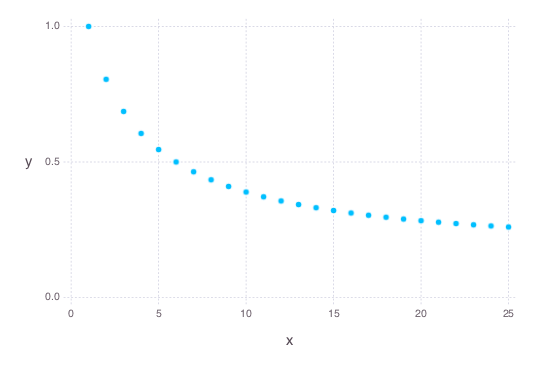

In [6]:
# graph of state over time 
plot(x=1:N, y=x[1, :])

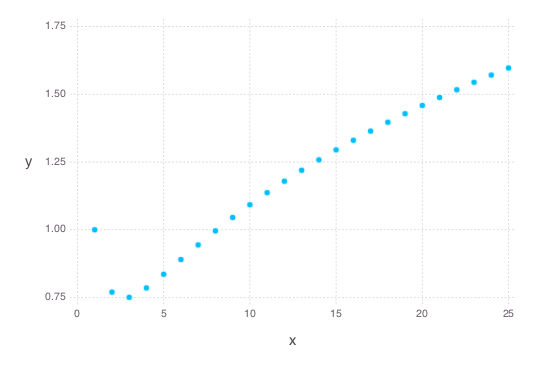

In [7]:
# graph of sensitivity (wrt r) over time 
plot(x=1:N, y=x[2, :])

In [8]:
@everywhere function phi(x, u, theta)
    if x[1] == 0 
        return 0
    else
        return  x[1]*(1 - u) + (theta[2]/x[1])^2*(1 - u)*x[2]^2 
    end
end

In [9]:
@everywhere nx1 = 50
@everywhere nx2 = 50
@everywhere xgrid = (linspace(0, 1, nx1), linspace(-1, 1, nx2)) 
@everywhere ugrid = 0:0.01:1; 

In [10]:
@everywhere function step(t, x, ugrid, theta, V, f)
    V_max = -Inf       # maximum value
    u_max = ugrid[1]    # maximizing input 
    for u = ugrid
        V_u = phi(x, u, theta) + V[f(t, x, u, theta)...] # dimension 2 hard-coded for now   
        # println(V_u)
        if V_u > V_max
            V_max = V_u
            # u_max = u
        end
    end
    return V_max
end
        

In [11]:
@everywhere function initialize(x, ugrid, theta)
    return 0
end

In [12]:
J_test = xgrid[1].^2 .+  xgrid[2]'.^2
V = interpolate(xgrid, J_test, Gridded(Linear()))
foo = step(1.0, [1.0; 0.0], ugrid, theta0, V, f)

2.0004164931278634

In [13]:
function dp(f, phi, ugrid, xgrid, theta0)
    J = zeros(nx1, nx2, N)
    for t=N-1:-1:1
        println(t)
        V = interpolate(xgrid, J[:, :, t+1], Gridded(Linear()))
        J[:, :, t] = pmap(x->step(t, x, ugrid, theta0, V, f), [[i, j] for i in xgrid[1], j in xgrid[2]])
    end
    return J
end

@time J = dp(f, phi, ugrid, xgrid, theta0); 

24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
 40.098797 seconds (41.68 M allocations: 4.263 GB, 1.38% gc time)


In [ ]:
plot(x=1:nx1, y=J[:, 25, N-1])

In [ ]:
using PyPlot

In [ ]:
surf(xgrid[1], xgrid[2], J[:, :, 1])

In [ ]:
workers()